In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import sys
sys.path.append('/home/cucchi/phd/devel/phd/')

In [21]:
import os
import xarray as xr
import math
import numpy as np
import matplotlib.pyplot as plt

from lab import analysis
from lab.simulation import forcings

In [22]:
REF_RESP_PATH = [
    '/home/cucchi/phd/data/response/lorenz96/rk4/SF_8_1.0_0/',
    '/home/cucchi/phd/data/response/lorenz96/rk4/SF_8_-1.0_0/'            
]
QUANTILES_PATH = '/home/cucchi/phd/data/obs/lorenz96/rk4/CF_8/quantiles/obs_lorenz96_rk4_CF_8_quantiles_energy.nc'

## Multiple Plots

In [23]:
force_linear_coefficient = 0.3
deactivation_time = 10
forcing = 'LF_8_{}_0_{}'.format(force_linear_coefficient, deactivation_time)

In [25]:
obs_all = ['energy_bin_{}q_{}q'.format(str(np.round(quant, 1)), str(np.round(quant + 0.1, 1))) for quant in np.arange(0, 0.9, 0.1)]
#obs_all = ['energy_bin_0.0q_{}q'.format(str(np.round(quant + 0.1, 1))) for quant in np.arange(0, 0.9, 0.1)]
obs_all.append('energy_exceed_0.9q')

Compute **susceptibilities**

In [26]:
chi_semidiff = {}
chi_normal = {}
for obs in obs_all:
    response_p1 = xr.open_dataarray(os.path.join(REF_RESP_PATH[0], 'response_lorenz96_rk4_{}_SF_8_1.0_0.nc'.format(obs)))
    response_m1 = xr.open_dataarray(os.path.join(REF_RESP_PATH[1], 'response_lorenz96_rk4_{}_SF_8_-1.0_0.nc'.format(obs)))
    response_semidiff = (response_p1 - response_m1)/2
    chi_semidiff[obs] = analysis.compute_susceptibility(response_semidiff.values.squeeze())
    chi_normal[obs] = analysis.compute_susceptibility(response_p1.values.squeeze())

FileNotFoundError: [Errno 2] No such file or directory: b'/home/cucchi/phd/data/response/lorenz96/rk4/SF_8_-1.0_0/response_lorenz96_rk4_energy_bin_0.0q_0.2q_SF_8_-1.0_0.nc'

Compute **predicted responses**

In [63]:
resp_real = {}
resp_pred_semidiff = {}
resp_pred_normal = {}
for obs in obs_all:
    resp_real[obs] = xr.open_dataarray(
        '/home/cucchi/phd/data/response/lorenz96/rk4/{f}/response_lorenz96_rk4_{o}_{f}.nc'.format(
            o=obs,
            f=forcing
        )
    )
    resp_pred_semidiff[obs] = analysis.compute_response(chi_semidiff[obs], forcings.LinearForcing(
        linear_coefficient=force_linear_coefficient,
        deactivation_time=deactivation_time
    ))
    resp_pred_normal[obs] = analysis.compute_response(chi_normal[obs], forcings.LinearForcing(
        linear_coefficient=force_linear_coefficient,
        deactivation_time = deactivation_time
    ))

### Plots

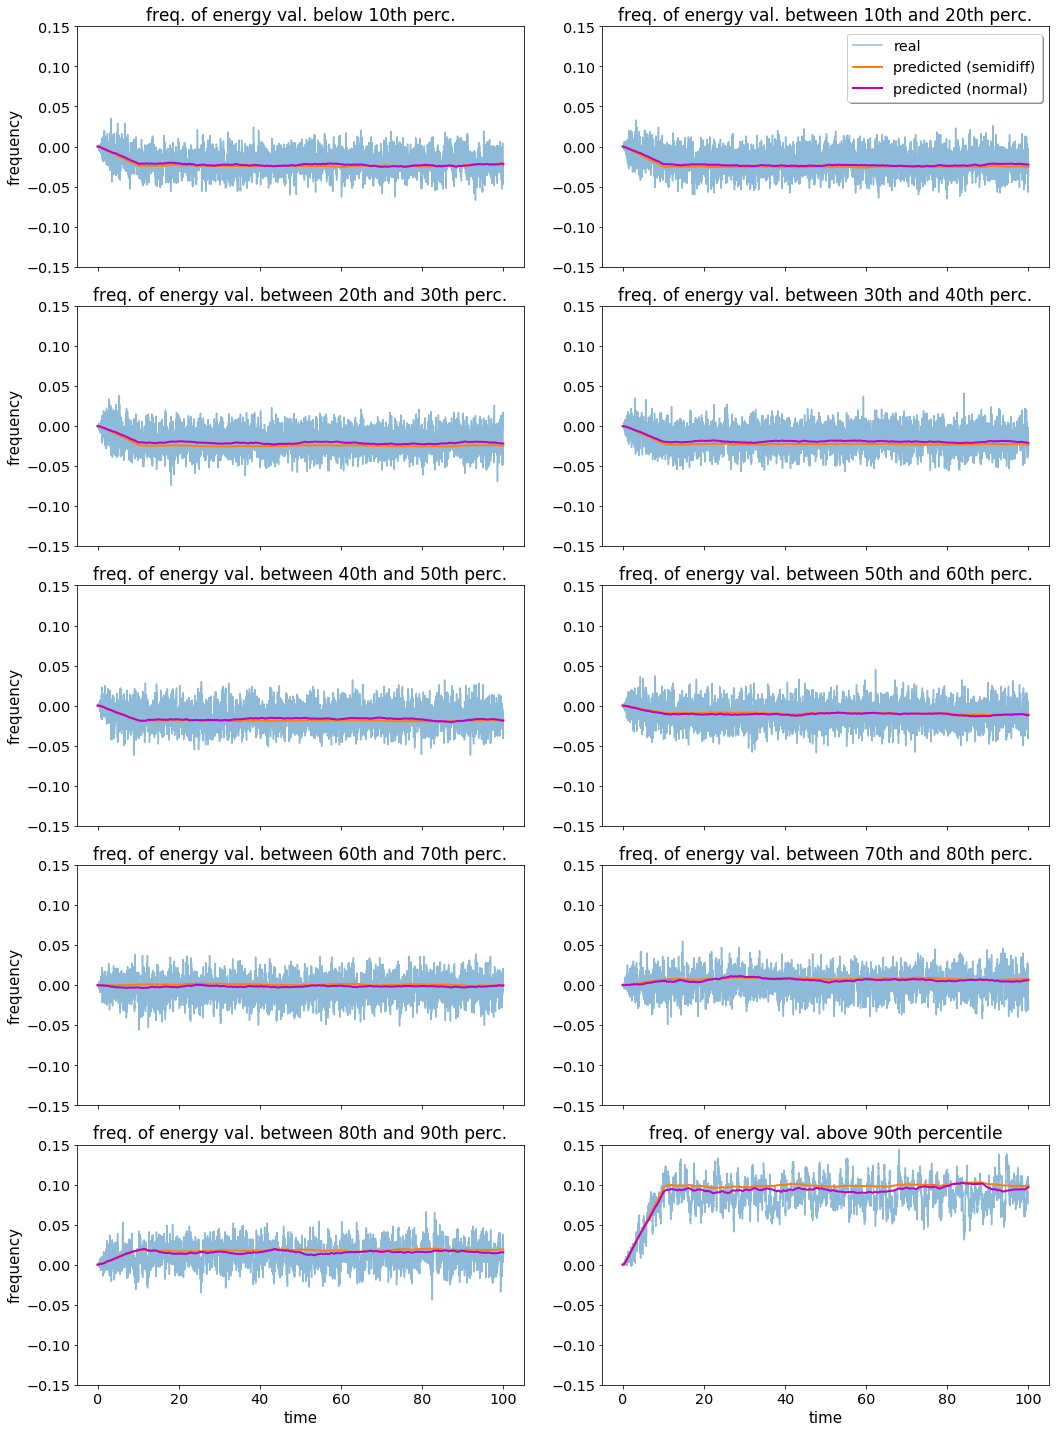

In [64]:
fig, ax = plt.subplots(5, 2, sharex='all', sharey=False, figsize=(15, 20))

titles = [
    'freq. of energy val. below 10th perc.',
    'freq. of energy val. between 10th and 20th perc.',
    'freq. of energy val. between 20th and 30th perc.',
    'freq. of energy val. between 30th and 40th perc.',
    'freq. of energy val. between 40th and 50th perc.',
    'freq. of energy val. between 50th and 60th perc.',
    'freq. of energy val. between 60th and 70th perc.',
    'freq. of energy val. between 70th and 80th perc.',
    'freq. of energy val. between 80th and 90th perc.',
    'freq. of energy val. above 90th percentile',
]

k = 0
for i in range(5):
    for j in range(2):
        l1, = ax[i, j].plot(np.arange(0, 100, 0.01), resp_real[obs_all[k]].values, alpha=0.5)
        l2, = ax[i, j].plot(np.arange(0, 100, 0.01), resp_pred_semidiff[obs_all[k]][0:10000], linewidth=2)
        l3, = ax[i, j].plot(np.arange(0, 100, 0.01), resp_pred_normal[obs_all[k]][0:10000], linewidth=2, color='m')
        ax[i, j].set_title(titles[k], size=17)
        ax[i, j].set_ylim([-0.15, 0.15])
        ax[i, j].tick_params(labelsize='x-large')
        std_real = resp_real[obs_all[k]].std().values
        avg_real = resp_real[obs_all[k]].mean().values
        sig_digit_real = -math.floor(math.log10(std_real))
        std_pred_normal = resp_pred_normal[obs_all[k]][0:10000].std()
        avg_pred_normal = resp_pred_normal[obs_all[k]][0:10000].mean()
        sig_digit_pred_normal = -math.floor(math.log10(std_pred_normal))
        std_pred_semidiff = resp_pred_semidiff[obs_all[k]][0:10000].std()
        avg_pred_semidiff = resp_pred_semidiff[obs_all[k]][0:10000].mean()
        sig_digit_pred_semidiff = -math.floor(math.log10(std_pred_semidiff))

        if k==1:
            ax[i, j].legend((l1, l2, l3), ('real', 'predicted (semidiff)', 'predicted (normal)'), loc='upper right', shadow=True, fontsize='x-large')
        if not j%2:
            ax[i, j].set_ylabel('frequency', size=15)
        if i==4:
            ax[i, j].set_xlabel('time', size=15)
            
        k += 1
        
plt.tight_layout()
plt.savefig('/home/cucchi/phd/devel/phd/logbook/fig/pred_bin_L_03_10.png')

## Single Plot

In [195]:
force_linear_coefficient = 0.1
deactivation_time = 10
forcing = 'LF_8_{}_0_{}'.format(force_linear_coefficient, deactivation_time)
obs = 'energy_exceed_0.99q'

In [196]:
response_p1 = xr.open_dataarray(os.path.join(REF_RESP_PATH[0], 'response_lorenz96_rk4_{}_SF_8_1.0_0.nc'.format(obs)))
response_m1 = xr.open_dataarray(os.path.join(REF_RESP_PATH[1], 'response_lorenz96_rk4_{}_SF_8_-1.0_0.nc'.format(obs)))
response_semidiff = (response_p1 - response_m1)/2
chi_semidiff = analysis.compute_susceptibility(response_semidiff.values.squeeze())
chi_normal = analysis.compute_susceptibility(response_p1.values.squeeze())

resp_real = xr.open_dataarray(
    '/home/cucchi/phd/data/response/lorenz96/rk4/{f}/response_lorenz96_rk4_{o}_{f}.nc'.format(
        o=obs,
        f=forcing
    )
)
resp_pred_semidiff = analysis.compute_response(chi_semidiff, forcings.LinearForcing(
    linear_coefficient=force_linear_coefficient,
    deactivation_time=deactivation_time
))
resp_pred_normal = analysis.compute_response(chi_normal , forcings.LinearForcing(
    linear_coefficient=force_linear_coefficient,
    deactivation_time = deactivation_time
))

### Plot

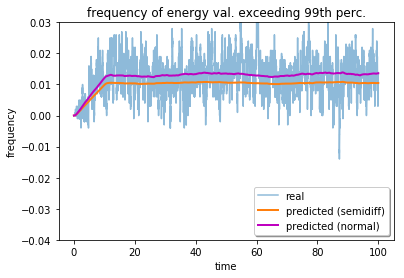

In [197]:
l1, = plt.plot(np.arange(0, 100, 0.01), resp_real.values, alpha=0.5)
l2, = plt.plot(np.arange(0, 100, 0.01), resp_pred_semidiff[0:10000], linewidth=2)
l3, = plt.plot(np.arange(0, 100, 0.01), resp_pred_normal[0:10000], linewidth=2, color='m')
#plt.set_title(titles[k], size=17)
plt.ylim(-0.04, 0.030)
#plt.tick_params(labelsize='x-normal')
std_real = resp_real.std().values
avg_real = resp_real.mean().values
sig_digit_real = -math.floor(math.log10(std_real))
std_pred_normal = resp_pred_normal[0:10000].std()
avg_pred_normal = resp_pred_normal[0:10000].mean()
sig_digit_pred_normal = -math.floor(math.log10(std_pred_normal))
std_pred_semidiff = resp_pred_semidiff[0:10000].std()
avg_pred_semidiff = resp_pred_semidiff[0:10000].mean()
sig_digit_pred_semidiff = -math.floor(math.log10(std_pred_semidiff))
plt.legend((l1, l2, l3), ('real', 'predicted (semidiff)', 'predicted (normal)'), loc='lower right', shadow=True)
plt.title('frequency of energy val. exceeding 99th perc.')
plt.ylabel('frequency')
plt.xlabel('time')
plt.savefig('/home/cucchi/phd/devel/phd/logbook/fig/pred_{}_L_{}_{}.png'.format(
    obs.replace('.', ''), str(force_linear_coefficient).replace('.', ''), str(deactivation_time)#
))

### Plot cumulative distribution approximation

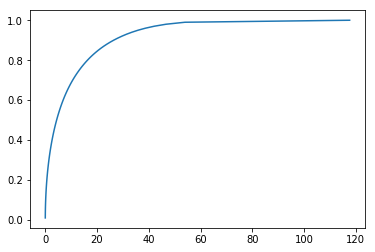

In [5]:
quantiles = xr.open_dataarray(QUANTILES_PATH)
x = quantiles.values[1:]
y = quantiles.quantile_order[1:]
plt.plot(x, y)

In [6]:
force_linear_coefficient = 0.01
deactivation_time = 100
forcing = 'LF_8_{}_0_{}'.format(force_linear_coefficient, deactivation_time)

In [9]:
obs_all = ['energy_bin_0.0q_{}q'.format(str(np.round(quant + 0.01, 2))) for quant in np.arange(0, 1.0, 0.01)]
chi_normal = {}
for obs in obs_all:
    response_p1 = xr.open_dataarray(os.path.join(REF_RESP_PATH[0], 'response_lorenz96_rk4_{}_SF_8_1.0_0.nc'.format(obs)))
    chi_normal[obs] = analysis.compute_susceptibility(response_p1.values.squeeze())
resp_pred_normal = {}
for obs in obs_all:
    resp_pred_normal[obs] = analysis.compute_response(chi_normal[obs], forcings.LinearForcing(
        linear_coefficient=force_linear_coefficient,
        deactivation_time = deactivation_time
    ))

In [10]:
resp_pred_normal_t50 = [resp_pred_normal[obs][5000] for obs in obs_all]
y_pred_t50 = y + resp_pred_normal_t50
resp_pred_normal_t100 = [resp_pred_normal[obs][9999] for obs in obs_all]
y_pred_t100 = y + resp_pred_normal_t100

#### Plot CDF

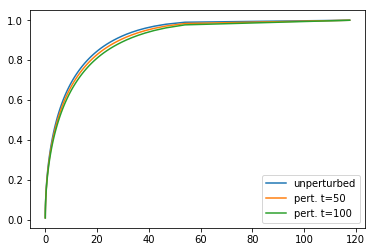

In [14]:
plt.plot(x, y, label='unperturbed')
plt.plot(x, y_pred_t50, label='pert. t=50')
plt.plot(x, y_pred_t100, label='pert. t=100')
plt.legend()

#### Plot PDF

In [16]:
x_pdf_orig = np.diff(x)/2
y_pdf_orig = np.diff(y)/np.diff(x)
y_pdf_t_100 = np.diff(y + resp_pred_normal_t100)/np.diff(x)

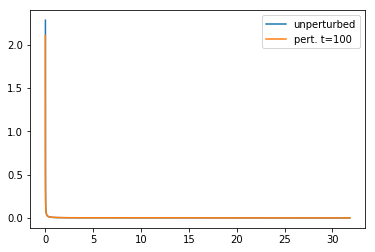

In [17]:
plt.plot(x_pdf_orig, y_pdf_orig, label='unperturbed')
plt.plot(x_pdf_orig, y_pdf_t_100, label='pert. t=100')
plt.legend()

(0, 0.1)

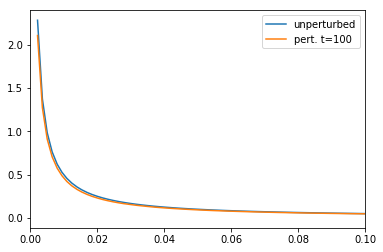

In [18]:
plt.plot(x_pdf_orig, y_pdf_orig, label='unperturbed')
plt.plot(x_pdf_orig, y_pdf_t_100, label='pert. t=100')
plt.legend()
plt.xlim(0,0.1)